In [47]:
import SimpleITK as sitk
import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

interrsect_1_path = '/Users/josephinebregazzi/Work/summer2023/work/Brain-Scan-Example-Data/Intersect/images/INTERRSeCT01-005_FollowUp.nii.gz'
isles22_1_path = '/Users/josephinebregazzi/Work/summer2023/work/Isles-22-Flair-Image-Preprocessing/sub-strokecase0002_ses-0001_flair.nii.gz'

reader = sitk.ImageFileReader()
reader.SetImageIO("NiftiImageIO")
reader.SetFileName(interrsect_1_path)

image = reader.Execute()

In [48]:
def myshow(image):
    ''' Takes in an image of dim=0, and displays the image inline.'''
    plt.imshow(sitk.GetArrayViewFromImage(image))
    plt.axis("off")
    plt.show()
    

In [49]:
def getSlices_img(image):
    slices = []
    depth = image.GetDepth
    
    if depth == 0:
        return image
    
    for i in range(depth):
        slices.append(image[i])
        
    return slices

In [50]:
print(image.GetDepth())
print(image.GetWidth())
print(image.GetHeight())

48
376
512


In [69]:
nda = sitk.GetArrayFromImage(image)
slices_nda = []
slices_img = []

print(nda.shape)

for i in range(image.GetDepth()):
    slices_nda.append(nda[i])
    slices_img.append(sitk.GetImageFromArray(slices_nda[i]))
    
print(len(slices_nda))
print(slices_nda[1].shape)
print(slices_img[1].GetSize())
    

(48, 512, 376)
48
(512, 376)
(376, 512)


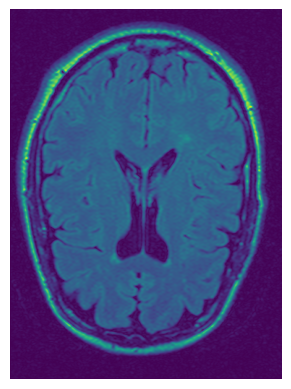

In [70]:
myshow(slices_img[28])

In [77]:
import sys

def segmentParts(args):
    if len(args) < 10:
        print(
            "Usage:",
            "FastMarchingSegmentation",
            "<inputImage> <outputImage> <seedX> <seedY> <Sigma>",
            "<SigmoidAlpha> <SigmoidBeta> <TimeThreshold>",
            "<StoppingTime>"
        )
        sys.exit(1)

    inputFilename = args[1]
    outputFilename = args[2]

    seedPosition = (int(args[3]), int(args[4]))

    sigma = float(args[5])
    alpha = float(args[6])
    beta = float(args[7])
    timeThreshold = float(args[8])
    stoppingTime = float(args[9])

    inputImage = sitk.ReadImage(inputFilename, sitk.sitkFloat32)

    smoothing = sitk.CurvatureAnisotropicDiffusionImageFilter()
    smoothing.SetTimeStep(0.125)
    smoothing.SetNumberOfIterations(5)
    smoothing.SetConductanceParameter(9.0)
    smoothingOutput = smoothing.Execute(inputImage)

    gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
    gradientMagnitude.SetSigma(sigma)
    gradientMagnitudeOutput = gradientMagnitude.Execute(smoothingOutput)

    sigmoid = sitk.SigmoidImageFilter()
    sigmoid.SetOutputMinimum(0.0)
    sigmoid.SetOutputMaximum(1.0)
    sigmoid.SetAlpha(alpha)
    sigmoid.SetBeta(beta)
    sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)

    fastMarching = sitk.FastMarchingImageFilter()

    seedValue = 0
    trialPoint = (seedPosition[0], seedPosition[1], seedValue)

    fastMarching.AddTrialPoint(trialPoint)

    fastMarching.SetStoppingValue(stoppingTime)

    fastMarchingOutput = fastMarching.Execute(sigmoidOutput)

    thresholder = sitk.BinaryThresholdImageFilter()
    thresholder.SetLowerThreshold(0.0)
    thresholder.SetUpperThreshold(timeThreshold)
    thresholder.SetOutsideValue(0)
    thresholder.SetInsideValue(255)

    result = thresholder.Execute(fastMarchingOutput)

    sitk.WriteImage(result, outputFilename)

    image_dict = {"InputImage": inputImage,
                  "SpeedImage": sigmoidOutput,
                  "TimeCrossingMap": fastMarchingOutput,
                  "Segmentation": result,
                  }
    return image_dict


img_dict = segmentParts(['BrainProtonDensitySlice.png', 'fastMarchingOutput.mha', 81, 114, 1.0, -0.5, 3.0, 100, 110])

Usage: FastMarchingSegmentation <inputImage> <outputImage> <seedX> <seedY> <Sigma> <SigmoidAlpha> <SigmoidBeta> <TimeThreshold> <StoppingTime>


SystemExit: 1